Epoch 1 | Train: 0.004594 | Val: 0.003731
Epoch 2 | Train: 0.003639 | Val: 0.003446
Epoch 3 | Train: 0.003426 | Val: 0.003272
Epoch 4 | Train: 0.004839 | Val: 0.003113
Epoch 5 | Train: 0.003126 | Val: 0.003119
Epoch 6 | Train: 0.003667 | Val: 0.002921
Epoch 7 | Train: 0.003884 | Val: 0.002827
Epoch 8 | Train: 0.002751 | Val: 0.002740
Epoch 9 | Train: 0.002773 | Val: 0.002615
Epoch 10 | Train: 0.015640 | Val: 0.002910
Epoch 11 | Train: 0.003060 | Val: 0.002607
Epoch 12 | Train: 0.002508 | Val: 0.002585
Epoch 13 | Train: 0.032849 | Val: 0.002741
Epoch 14 | Train: 0.003060 | Val: 0.002801
Epoch 15 | Train: 0.002767 | Val: 0.002644
Epoch 16 | Train: 0.005057 | Val: 0.002607
Epoch 17 | Train: 0.002514 | Val: 0.002620
Early stopping triggered
Best threshold: 0.5550766994807527
Precision: 1.0
Recall: 0.7
F1-score: 0.8235294117647058
ROC-AUC: 0.7696531115068426


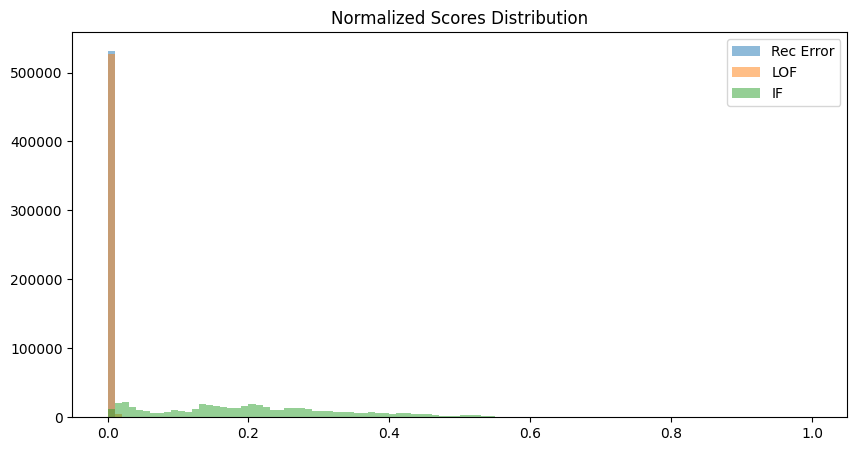

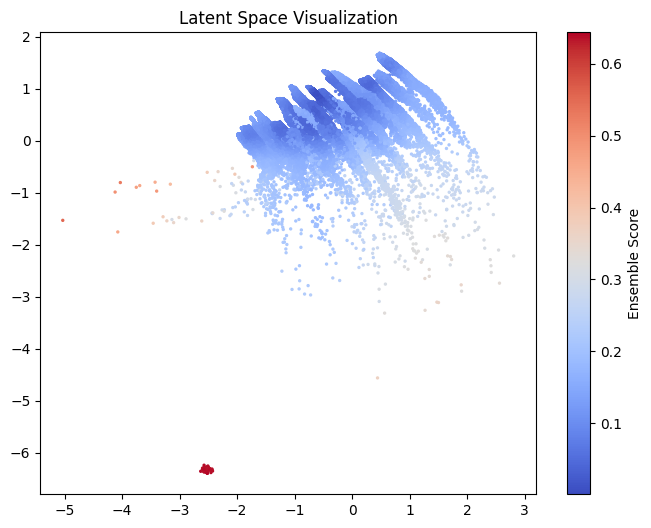

In [51]:
# =============================
# Imports
# =============================
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# =============================
# Load dữ liệu
# =============================
data_path = "../data/raw/fraud_dataset_v1.csv"
df = pd.read_csv(data_path)
labels = df['label'].values
df = df.drop(columns=['label'])

# =============================
# Preprocessing
# =============================
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(include=[object]).columns

df_numeric = StandardScaler().fit_transform(df[numeric_cols])

if len(categorical_cols) > 0:
    df_cat = OneHotEncoder(sparse_output=False).fit_transform(df[categorical_cols])
    X = np.hstack([df_numeric, df_cat])
else:
    X = df_numeric

X = X.astype(np.float32)

# Split train / val
train_size = int(0.8 * len(X))
val_size = len(X) - train_size
train_data, val_data = random_split(X, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1024, shuffle=False)

# =============================
# Autoencoder with Early Stopping
# =============================
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim,128), nn.ReLU(),
            nn.Linear(128,64), nn.ReLU(),
            nn.Linear(64,latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,64), nn.ReLU(),
            nn.Linear(64,128), nn.ReLU(),
            nn.Linear(128,input_dim)
        )
    def forward(self,x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

input_dim = X.shape[1]
latent_dim = 3
ae = Autoencoder(input_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)

# Early stopping setup
best_val_loss = np.inf
patience = 5
counter = 0
best_model_state = None

for epoch in range(50):
    ae.train()
    train_loss = 0
    for batch in train_loader:
        x_batch = batch[0]
        optimizer.zero_grad()
        x_hat, _ = ae(x_batch)
        loss = criterion(x_hat, x_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation
    ae.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            x_batch = batch[0]
            x_hat, _ = ae(x_batch)
            loss = criterion(x_hat, x_batch)
            val_loss += loss.item() * x_batch.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1} | Train: {train_loss:.6f} | Val: {val_loss:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = ae.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

ae.load_state_dict(best_model_state)

# =============================
# Compute reconstruction error & latent vectors
# =============================
ae.eval()
with torch.no_grad():
    X_tensor = torch.from_numpy(X)
    X_hat, Z = ae(X_tensor)
    rec_error = ((X_tensor - X_hat)**2).mean(dim=1).numpy()
    latent_vectors = Z.numpy()

# =============================
# LOF & IF (tuned)
# =============================
lof = LocalOutlierFactor(n_neighbors=20, novelty=True)
lof.fit(latent_vectors)
lof_scores = -lof.decision_function(latent_vectors)

if_model = IsolationForest(n_estimators=200, contamination=0.01, random_state=42)
if_model.fit(latent_vectors)
if_scores = -if_model.score_samples(latent_vectors)

# =============================
# 1. Chuẩn hóa labels
# =============================
# Nếu labels gốc là string như 'regular', 'local', 'global'
# Ánh xạ nhãn
label_map = {"regular": 0, "local": 1, "global": 1}

def map_label(l):
    if isinstance(l, str):
        return label_map.get(l, 0)  # mặc định map các giá trị lạ thành 0
    try:
        return int(l)
    except:
        return 0  # các giá trị không convert được -> 0

labels_numeric = np.array([map_label(l) for l in labels])


# =============================
# 2. Normalize ensemble scores
# =============================
from sklearn.preprocessing import MinMaxScaler
scores_stack = np.vstack([rec_error, lof_scores, if_scores]).T
scores_norm = MinMaxScaler().fit_transform(scores_stack)
rec_error_norm, lof_scores_norm, if_scores_norm = scores_norm[:,0], scores_norm[:,1], scores_norm[:,2]

# Ensemble score
alpha, beta, gamma = 0.4, 0.3, 0.3
ensemble_score = alpha*rec_error_norm + beta*lof_scores_norm + gamma*if_scores_norm

# =============================
# 3. Tìm threshold tối ưu dựa trên F1
# =============================
best_f1 = 0
best_thresh = 0

for thresh in np.linspace(0, ensemble_score.max(), 1000):
    preds = (ensemble_score >= thresh).astype(int)
    f1 = f1_score(labels_numeric, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

# Gán nhãn cuối cùng
preds = (ensemble_score >= best_thresh).astype(int)

# =============================
# 4. Đánh giá model
# =============================
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

print("Best threshold:", best_thresh)
print("Precision:", precision_score(labels_numeric, preds))
print("Recall:", recall_score(labels_numeric, preds))
print("F1-score:", f1_score(labels_numeric, preds))
print("ROC-AUC:", roc_auc_score(labels_numeric, ensemble_score))

# =============================
# 5. Visualization
# =============================
import matplotlib.pyplot as plt

# Histogram các score
plt.figure(figsize=(10,5))
plt.hist(rec_error_norm, bins=100, alpha=0.5, label="Rec Error")
plt.hist(lof_scores_norm, bins=100, alpha=0.5, label="LOF")
plt.hist(if_scores_norm, bins=100, alpha=0.5, label="IF")
plt.legend()
plt.title("Normalized Scores Distribution")
plt.show()

# Scatter plot latent space
plt.figure(figsize=(8,6))
plt.scatter(latent_vectors[:,0], latent_vectors[:,1], c=ensemble_score, cmap='coolwarm', s=2)
plt.colorbar(label='Ensemble Score')
plt.title("Latent Space Visualization")
plt.show()



In [50]:
print(np.unique(labels))

['global' 'local' 'regular']
